In [ ]:
import sys
# Add the parent directory to the system path
sys.path.insert(1, r"C:\Users\keena\Documents\University\python_scripts")

from Function_files.addresses import Init_Directories
import Function_files.data_functions as df

from Function_files.plotting_class import Plotter

import os

plt = Plotter()
dirs = Init_Directories()

import matplotlib.pyplot as mp
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.integrate import simpson
from scipy.optimize import curve_fit
import pandas as pd
import math

mp.style.use(r'C:\Users\keena\Documents\University\python_scripts\Function_files\signature.mplstyle')


##### Set Directory and Args
        
        Define the directory to extract files from and provide discriminators


In [ ]:
directory = r"C:\Users\keena\Downloads"
folder = 'linewidth'

path = os.path.join(directory, folder)
exts = ('.csv')
exceptions = ['.png', '.json']

# interogate directory to extract folder and file names
folder_list, file_list = df.dir_interrogate(path, exts, exceptions)

# create file paths
paths = []
for n, folder in enumerate(folder_list):
    temp = []
    temp_path = os.path.join(path, folder)
    for file in file_list[n]:
        temp.append(os.path.join(temp_path, file))
    paths.append(temp)

excel_files = [[df.open_csv(file, header=0) for file in folder] for folder in paths]

In [ ]:
def AOM_WCP_606_Efficiency(Sine_Voltage, Single_Pass_Power):
    Efficiency = 0.7062527710009873 * np.exp(-(Sine_Voltage - 231.74917120201272)**2 / (2 * 72.06094381524552**2))
    Power = Single_Pass_Power * Efficiency
    return Power

In [ ]:
def AOM_Prep_606_Efficiency(Sine_Voltage, Single_Pass_Power):
    Efficiency = 0.6344733319458099 * np.exp(-(Sine_Voltage - 235.2485990922679)**2 / (2 * 72.45100268498064**2))
    Power = Single_Pass_Power * Efficiency
    return Power

In [ ]:
Sine_Voltage_linespace = np.linspace(50, 200, 15)
Power_list = []
sine_Voltage_list = []
for i , Sine_Voltage_linespace in enumerate(Sine_Voltage_linespace):
    Power_list.append(AOM_Prep_606_Efficiency(Sine_Voltage_linespace, 2))
    sine_Voltage_list.append(Sine_Voltage_linespace)

Power_list

In [ ]:
q_ref_max, qq_ref_max = [], []
i, w = 3, 1
for pp in range(len(excel_files[i][w][:,0])):
    
    x_first, y_first = excel_files[i][w][0,0], excel_files[i][w][0,2]
    x_last, y_last = excel_files[i][w][-1,0], excel_files[i][w][-1,2]
    slope = (y_last - y_first) / (x_last - x_first)
    baseline = slope * excel_files[i][w][pp,0]
    q_ref_max.append(excel_files[i][w][pp,0] * 2000)
    qq_ref_max.append((excel_files[i][w][pp,2] - baseline) - excel_files[i][w][0,2])
mp.plot(q_ref_max, qq_ref_max, label='Max Transmission')

q_ref_min, qq_ref_min = [], []
i, w = 3, 2
for pp in range(len(excel_files[i][w][:,0])):
    x_first, y_first = excel_files[i][w][0,0], excel_files[i][w][0,2]
    x_last, y_last = excel_files[i][w][-1,0], excel_files[i][w][-1,2]
    slope = (y_last - y_first) / (x_last - x_first)
    baseline = slope * excel_files[i][w][pp,0]
    
    
    q_ref_min.append(excel_files[i][w][pp,0] * 2000)
    qq_ref_min.append((excel_files[i][w][pp,2]  - baseline) - excel_files[i][w][0,2])
mp.plot(q_ref_min, qq_ref_min, label='Max Absorption')

#mp.gca().invert_yaxis()
mp.xlabel('Frequency (MHz)')
mp.title('Pit')
mp.ylabel('Voltage (V)')
mp.legend()
mp.show()

mp.figure() 

q, qq = [], []
for pp in range(len(q_ref_max)):
    if -5.9< q_ref_max[pp] < 5.9:
        q.append(q_ref_max[pp])
        qq.append(np.log(qq_ref_max[pp]/qq_ref_max[pp]))
mp.plot(q, qq, label='Max Transmission')

q, qq = [], []
for pp in range(len(q_ref_max)):
    if -1.9< q_ref_max[pp] < 1.9:
        q.append(q_ref_min[pp])
        qq.append(np.log(qq_ref_max[pp]/qq_ref_min[pp]))
mp.plot(q, qq, label='Max Absorption')


#mp.gca().invert_yaxis()
mp.xlabel('Frequency (MHz)')
mp.title('Pit')
mp.ylabel('OD')
mp.legend()
mp.show()

In [ ]:
x = excel_files[i][w][:,0] 
y = excel_files[i][w][:,2]

x_first, y_first = excel_files[i][w][0,0], excel_files[i][w][0,2]
x_last, y_last = excel_files[i][w][-1,0], excel_files[i][w][-1,2]
slope = (y_last - y_first) / (x_last - x_first)
intercept = y_first - slope * x_first
baseline = slope * x + intercept
y_corrected = y - baseline

mp.plot(x, y, label='Original Data')
mp.plot(x, baseline, label='Baseline', linestyle='--')
mp.plot(x, y_corrected, label='Corrected Data')
mp.xlabel('X Axis Label')
mp.ylabel('Y Axis Label')
mp.title('Baseline Correction')
mp.legend()
mp.show()

In [ ]:
def gaussian(x, amplitude, mean, stddev, B):
    return -amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2) + B

indexes = [4,5,6]
fwhm_list_1 = []
fwhm_list_g = []

for l,i in enumerate(indexes):
    
    FWHM_list = []
    for w in range(len(Power_list)):
        if w > -1:
            q_ref, qq_ref = [], []
            for pp in range(len(excel_files[i][w][:,0])):
                x_first, y_first = excel_files[i][w][0,0], excel_files[i][w][0,2]
                x_last, y_last = excel_files[i][w][-1,0], excel_files[i][w][-1,2]
                slope = (y_last - y_first) / (x_last - x_first)
                baseline = slope * excel_files[i][w][pp,0]
                if -0.002< excel_files[i][w][pp,0] < 0.002:
                    q_ref.append(excel_files[i][w][pp,0] * 2000)
                    qq_ref.append(excel_files[i][w][pp,2] - excel_files[i][w][0,2] - baseline)
            q, qq = [], []
            for p in range(len(q_ref)):
                if -1.6< q_ref[p] < 1.8:
                    q.append(q_ref[p])
                    qq.append(np.log(qq_ref_max[p]/qq_ref[p]))
        
            # Initial guess for amplitude, mean, stddev, and B
            initial_guess =  [0.5, 0, 0.2, 1.5]
            params, covariance = curve_fit(gaussian, q, qq, p0=initial_guess)
            amp_opt, mean_opt, stddev_opt, B_Opt = params
            fwhm = 2.355 * stddev_opt
            FWHM_list.append(fwhm * 10**3)
    
    fwhm_list_g.append(FWHM_list)

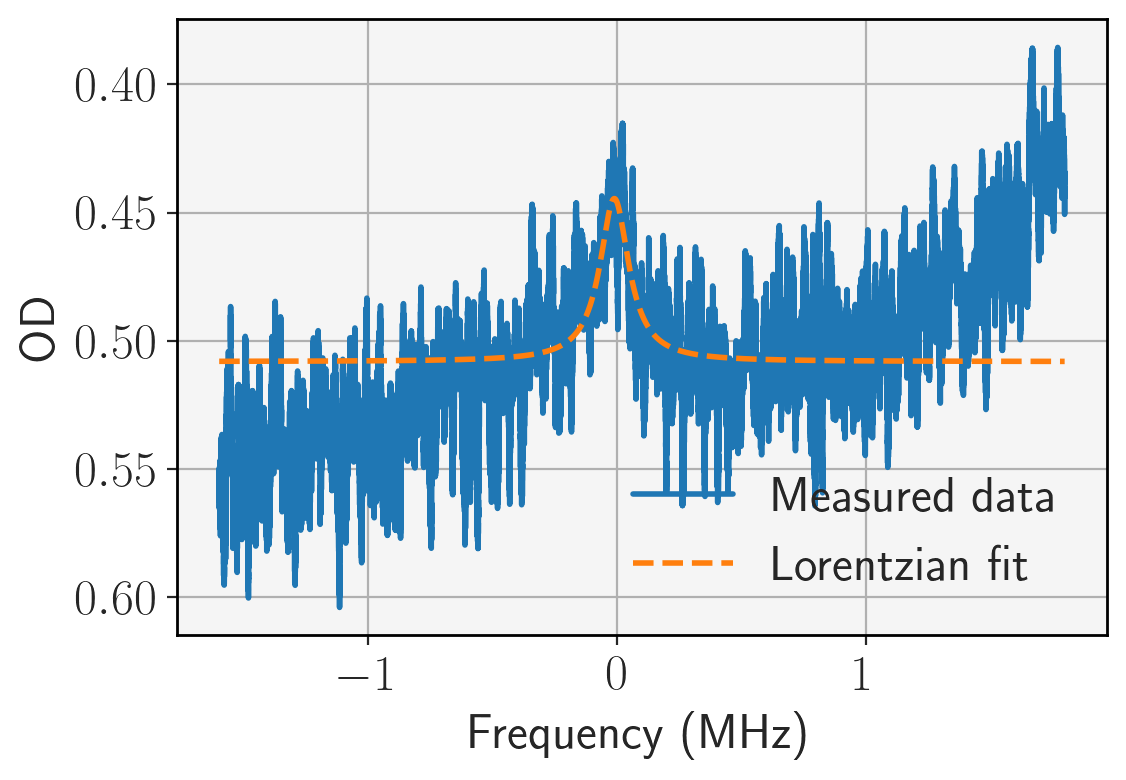

In [19]:
# Define the Gaussian function
def lorentzian(x, amp:float, x_0:float, gamma:float, y_0:float):
    return (amp * ((0.5*gamma)**2/((x-x_0)**2 + (0.5*gamma)**2))) + y_0

indexes = [0,1,2]
fwhm_list_1 = []
fwhm_list_lock = []

for l,i in enumerate(indexes):
    FWHM_list = []
    for w in range(len(Power_list)):
        if w > -1:
            q_ref, qq_ref = [], []
            for pp in range(len(excel_files[i][w][:,0])):
                x_first, y_first = excel_files[i][w][0,0], excel_files[i][w][0,2]
                x_last, y_last = excel_files[i][w][-1,0], excel_files[i][w][-1,2]
                slope = (y_last - y_first) / (x_last - x_first)
                baseline = slope * excel_files[i][w][pp,0]
                if -0.002< excel_files[i][w][pp,0] < 0.002:
                    q_ref.append(excel_files[i][w][pp,0] * 2000)
                    qq_ref.append(excel_files[i][w][pp,2] - excel_files[i][w][0,2] - baseline)
            q, qq = [], []
            for p in range(len(q_ref)):
                if -1.6 < q_ref[p] < 1.8:
                    q.append(q_ref[p])
                    qq.append(np.log(qq_ref_max[p]/qq_ref[p]))
        
            # Initial guess for amplitude, mean, stddev, and B
            initial_guess =  [0.5, 0, 0.2, 1.5]
            params, covariance = curve_fit(lorentzian, q, qq, p0=initial_guess)
            amp_opt, mean_opt, stddev_opt, B_Opt = params
            fwhm = stddev_opt
            FWHM_list.append(fwhm * 10**3)
            
            if l == 1:
                if w == 0:
                    fig, ax =mp.subplots()
                    ax.plot(q, qq, label='Measured data')
                    ax.plot(q, lorentzian(q, amp_opt, mean_opt, stddev_opt, B_Opt), label='Lorentzian fit', color='C1', alpha=1, linestyle='--')
                    ax.set(xlabel='Frequency (MHz)', ylabel='OD')
                    #mp.title('Single pulse feature      SP amplitude: {:.3f} mV'.format(Sine_voltage_list_1ms[w]))
                    #mp.title('Lorentzian Fit       FWHM: {:.1f} KHz        SP amplitude: {:.3f} mV'.format(fwhm * 1e3, sine_Voltage_list[w]))
                    ax.invert_yaxis()
                    ax.legend(loc='lower right')
                    fig.savefig(fname='locked.svg', format='svg', bbox_inches='tight')
                    
    fwhm_list_lock.append(FWHM_list)

In [ ]:
# Define the Gaussian function
def lorentzian(x, amp:float, x_0:float, gamma:float, y_0:float):
    return (amp * ((0.5*gamma)**2/((x-x_0)**2 + (0.5*gamma)**2))) + y_0

indexes = [4,5,6]
fwhm_list_1 = []
fwhm_list_unlock = []

for l,i in enumerate(indexes):
    
    FWHM_list = []
    for w in range(len(Power_list)):
        if w > -1:
            q_ref, qq_ref = [], []
            for pp in range(len(excel_files[i][w][:,0])):
                x_first, y_first = excel_files[i][w][0,0], excel_files[i][w][0,2]
                x_last, y_last = excel_files[i][w][-1,0], excel_files[i][w][-1,2]
                slope = (y_last - y_first) / (x_last - x_first)
                baseline = slope * excel_files[i][w][pp,0]
                if -0.002< excel_files[i][w][pp,0] < 0.002:
                    q_ref.append(excel_files[i][w][pp,0] * 2000)
                    qq_ref.append(excel_files[i][w][pp,2] - excel_files[i][w][0,2] - baseline)
            q, qq = [], []
            for p in range(len(q_ref)):
                if -1.6< q_ref[p] < 1.8:
                    q.append(q_ref[p])
                    qq.append(np.log(qq_ref_max[p]/qq_ref[p]))
        
            # Initial guess for amplitude, mean, stddev, and B
            initial_guess =  [0.5, 0, 0.2, 1.5]
            params, covariance = curve_fit(lorentzian, q, qq, p0=initial_guess)
            amp_opt, mean_opt, stddev_opt, B_Opt = params
            fwhm = stddev_opt
            FWHM_list.append(fwhm * 10**3)
            
            fig, ax =mp.subplots()
            ax.plot(q, qq, label='Measured data')
            ax.plot(q, lorentzian(q, amp_opt, mean_opt, stddev_opt, B_Opt), label='Lorentzian fit', color='C1', alpha=1, linestyle='--')
            ax.set(xlabel='Frequency (MHz)', ylabel='OD')
            #mp.title('Single pulse feature      SP amplitude: {:.3f} mV'.format(Sine_voltage_list_1ms[w]))
            #mp.title('Lorentzian Fit       FWHM: {:.1f} KHz        SP amplitude: {:.3f} mV'.format(fwhm * 1e3, sine_Voltage_list[w]))
            ax.invert_yaxis()
            ax.legend()
            #fig.savefig(fname='unlocked.svg', dpi=80, format='svg', bbox_inches='tight')
    fwhm_list_unlock.append(FWHM_list)

In [ ]:
fwhm_list = fwhm_list_g

power_list = Power_list

width_arrays = np.array([fwhm_list[0], fwhm_list[1], fwhm_list[2]])

avg_width = np.mean(width_arrays, axis=0)

FWHM_list_avg = avg_width.tolist() 

std_width = np.std(width_arrays, axis=0)

mp.figure(figsize=(5, 3))

mp.errorbar(power_list, avg_width, yerr=std_width, fmt='o', label='Data Points', color='blue', capsize=5)

mp.xlabel('Power')
mp.ylabel('Width')
mp.title('Width vs. Power')
mp.grid(True)
mp.legend()
mp.show()


In [ ]:
import os

# Create a directory to save images (if it doesn't exist)
#save_dir = r"C:\Users\ms2316\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\Lab_Laptop\Stuff"
#os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist

# File paths
#svg_path = os.path.join(save_dir, "locked.svg")
#png_path = os.path.join(save_dir, "locked.png")


# Define the power function
def power_func(x, a, b):
    return a + (b * x**0.5)

# Define the index range
start_idx = 2
end_idx = -2
  
# Slice the data
power_list_subset = power_list[start_idx:end_idx]
FWHM_list_avg_subset = FWHM_list_avg[start_idx:end_idx]
avg_width_subset = avg_width[start_idx:end_idx]
std_width_subset = std_width[start_idx:end_idx]

# Initial guess for curve fitting
initial_guess = [20, 0.01]

# Fit the function to the subset of data
popt, pcov = curve_fit(power_func, power_list_subset, FWHM_list_avg_subset, p0=initial_guess)

# Generate fitted curve data for the same range
x_fit = np.linspace(0, max(power_list_subset)+ 0.05, 500)
y_fit = power_func(x_fit, *popt)

# Plot the fitted curve
mp.plot(x_fit, y_fit*1E-3, label='Fit to eq. (4.14)', color='C1')

# Calculate y-intercept
y_intercept = power_func(0, *popt)

# Plot experimental data with error bars
mp.errorbar(power_list_subset, avg_width_subset*1E-3, yerr=std_width_subset*1E-3, fmt='o', label='Exp. data', color='C0', capsize=4)

# Labels and title
mp.xlabel('Power (mW)')
mp.ylabel('Width (MHz)')
mp.legend()
#mp.title('Width in zero power: ' + str(round(y_intercept, 1)) + ' kHz')
print(f'Width in zero power: ' + str(round(y_intercept, 1)) + ' kHz')
print(f'{np.sqrt(np.diag(pcov))}')
# Save as SVG
mp.savefig(r"C:\Users\keena\Documents\University\python_scripts\PhD_Thesis\Figures\Chapter-4\Plots\unlocked_est.svg", format="svg")

In [ ]:
fwhm_list = fwhm_list_unlock

power_list = Power_list

width_arrays = np.array([fwhm_list[0], fwhm_list[1], fwhm_list[2]])

avg_width = np.mean(width_arrays, axis=0)

FWHM_list_avg = avg_width.tolist() 

std_width = np.std(width_arrays, axis=0)

mp.figure(figsize=(5, 3))

mp.errorbar(power_list, avg_width, yerr=std_width, fmt='o', label='Data Points', color='blue', capsize=5)

mp.xlabel('Power')
mp.ylabel('Width')
mp.title('Width vs. Power')
mp.grid(True)
mp.legend()
mp.show()


In [ ]:
import os

# Create a directory to save images (if it doesn't exist)
#save_dir = r"C:\Users\ms2316\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\Lab_Laptop\Stuff"
#os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist

# File paths
#svg_path = os.path.join(save_dir, "locked.svg")
#png_path = os.path.join(save_dir, "locked.png")


# Define the power function
def power_func(x, a, b):
    return a + (b * x**0.5)

# Define the index range
start_idx = 2
end_idx = None
  
# Slice the data
power_list_subset = power_list[start_idx:end_idx]
FWHM_list_avg_subset = FWHM_list_avg[start_idx:end_idx]
avg_width_subset = avg_width[start_idx:end_idx]
std_width_subset = std_width[start_idx:end_idx]

# Initial guess for curve fitting
initial_guess = [100, 0.01]

# Fit the function to the subset of data
popt, pcov = curve_fit(power_func, power_list_subset, FWHM_list_avg_subset, p0=initial_guess, bounds=([0,0], [500, np.inf]))

# Generate fitted curve data for the same range
x_fit = np.linspace(0, max(power_list_subset)+ 0.05, 500)
y_fit = power_func(x_fit, *popt)

# Plot the fitted curve
mp.plot(x_fit, y_fit, label='Extracted Linewidth', color='C1')

# Calculate y-intercept
y_intercept = power_func(0, *popt)

# Plot experimental data with error bars
mp.errorbar(power_list_subset, avg_width_subset, yerr=std_width_subset, fmt='o', label='Exp. data', color='C0', capsize=4)

# Labels and title
mp.xlabel('Power (mW)')
mp.ylabel('Width (KHz)')
mp.legend()
#mp.title('Width in zero power: ' + str(round(y_intercept, 1)) + ' kHz')
print(f'Width in zero power: ' + str(round(y_intercept, 4)) + ' kHz')
print(f'{np.sqrt(np.diag(pcov))}')
# Save as SVG
#mp.savefig(r"C:\Users\keena\Documents\University\python_scripts\PhD_Thesis\Figures\Chapter-4\Plots\unlocked.svg", format="svg")

In [ ]:
fwhm_list = fwhm_list_lock

power_list = Power_list

width_arrays = np.array([fwhm_list[0], fwhm_list[1], fwhm_list[2]])

avg_width = np.mean(width_arrays, axis=0)

FWHM_list_avg = avg_width.tolist() 

std_width = np.std(width_arrays, axis=0)

mp.figure(figsize=(5, 3))

mp.errorbar(power_list, avg_width, yerr=std_width, fmt='o', label='Data Points', color='blue', capsize=5)

mp.xlabel('Power')
mp.ylabel('Width')
mp.title('Width vs. Power')
mp.grid(True)
mp.legend()
mp.show()


In [ ]:
import os

# Create a directory to save images (if it doesn't exist)
#save_dir = r"C:\Users\ms2316\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\Lab_Laptop\Stuff"
#os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist

# File paths
#svg_path = os.path.join(save_dir, "locked.svg")
#png_path = os.path.join(save_dir, "locked.png")


# Define the power function
def power_func(x, a, b):
    return a + (b * x**0.5)

# Define the index range
start_idx = 2
end_idx = None
  
# Slice the data
power_list_subset = power_list[start_idx:end_idx]
FWHM_list_avg_subset = FWHM_list_avg[start_idx:end_idx]
avg_width_subset = avg_width[start_idx:end_idx]
std_width_subset = std_width[start_idx:end_idx]

# Initial guess for curve fitting
initial_guess = [100, 0.01]

# Fit the function to the subset of data
popt, pcov = curve_fit(power_func, power_list_subset, FWHM_list_avg_subset, p0=initial_guess, bounds=([0,0], [500, np.inf]))

# Generate fitted curve data for the same range
x_fit = np.linspace(0, max(power_list_subset)+ 0.05, 500)
y_fit = power_func(x_fit, *popt)

# Plot the fitted curve
mp.plot(x_fit, y_fit, label='Extracted Linewidth', color='C1')

# Calculate y-intercept
y_intercept = power_func(0, *popt)

# Plot experimental data with error bars
mp.errorbar(power_list_subset, avg_width_subset, yerr=std_width_subset, fmt='o', label='Exp. data', color='C0', capsize=4)

# Labels and title
mp.xlabel('Power (mW)')
mp.ylabel('Width (KHz)')
mp.legend()
#mp.title('Width in zero power: ' + str(round(y_intercept, 1)) + ' kHz')
print(f'Width in zero power: ' + str(round(y_intercept, 4)) + ' kHz')
print(f'{pcov}')
# Save as SVG
mp.savefig(r"C:\Users\keena\Documents\University\python_scripts\PhD_Thesis\Figures\Chapter-4\Plots\unlocked.svg", format="svg")